<a href="https://www.kaggle.com/code/hridoychandrasarker/notebookbff8bc6814?scriptVersionId=255026644" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Total ratings: 6337241
Unique users: 69600
Unique anime: 9927
Sparsity: 99.08%


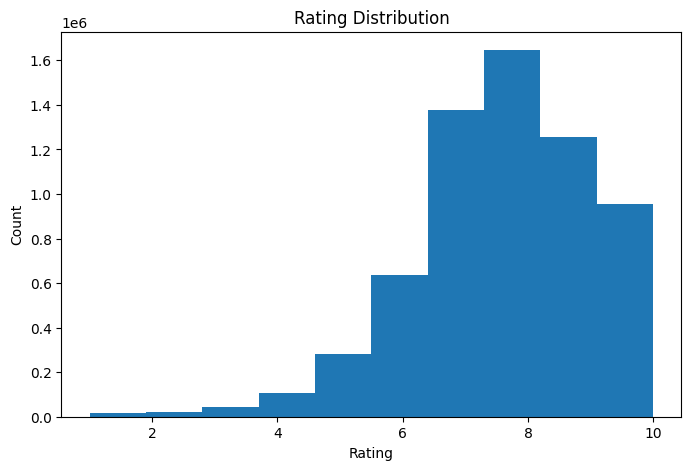

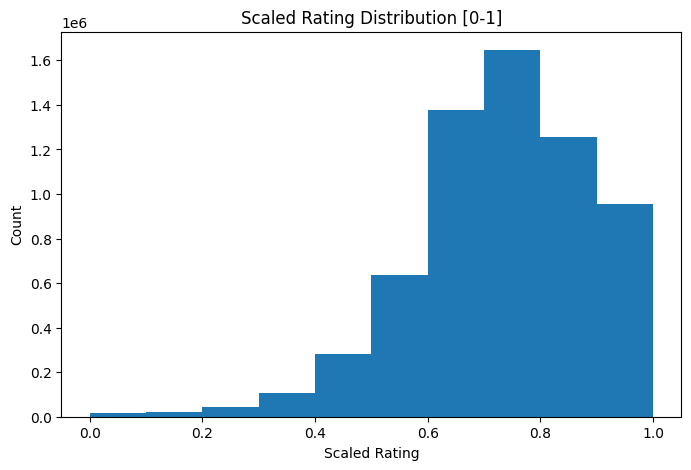

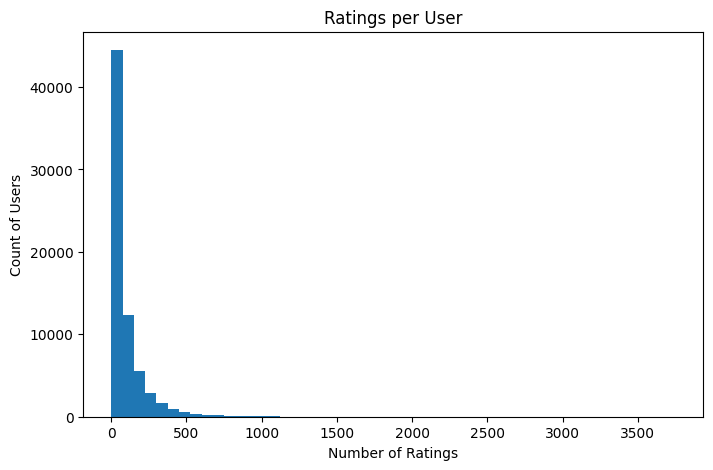

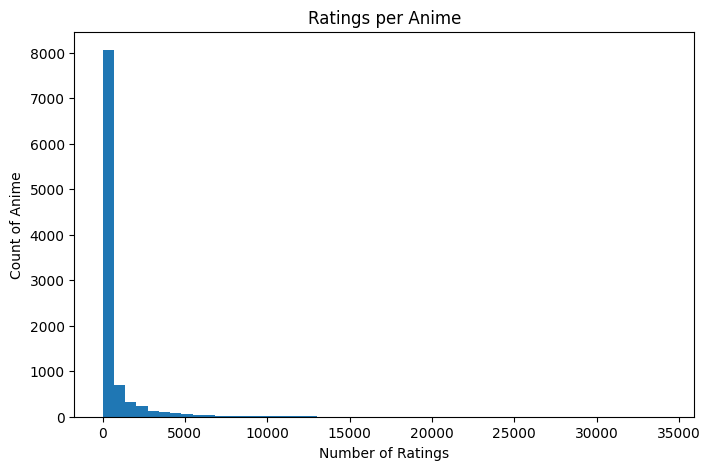

Epoch 1/40 - Train RMSE: 0.1371, Val RMSE: 0.1381
Epoch 2/40 - Train RMSE: 0.1344, Val RMSE: 0.1357
Epoch 3/40 - Train RMSE: 0.1335, Val RMSE: 0.1350
Epoch 4/40 - Train RMSE: 0.1330, Val RMSE: 0.1345
Epoch 5/40 - Train RMSE: 0.1327, Val RMSE: 0.1344
Epoch 6/40 - Train RMSE: 0.1326, Val RMSE: 0.1343
Epoch 7/40 - Train RMSE: 0.1324, Val RMSE: 0.1342


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

class MatrixFactorization:
    def __init__(self, train_df, val_df, n_factors=20, l_rate=0.01, reg=0.05, n_iter=40):
        self.train_df = train_df
        self.val_df = val_df
        self.n_users = max(train_df['user_idx'].max(), val_df['user_idx'].max()) + 1
        self.n_items = max(train_df['anime_idx'].max(), val_df['anime_idx'].max()) + 1
        self.n_factors = n_factors
        self.l_rate = l_rate
        self.reg = reg
        self.n_iter = n_iter
        self.train_rmse_lst = []
        self.val_rmse_lst = []
        self.verbose = True
    
    def initialize(self):
        self.now = time.time()
        # Global bias from train
        self.global_bias = np.mean(self.train_df['scaled_rating'])
        # User and item biases
        self.user_biases = np.zeros(self.n_users)
        self.item_biases = np.zeros(self.n_items)
        # Latent factors
        self.user_vecs = np.random.normal(scale=1./self.n_factors, size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors, size=(self.n_items, self.n_factors))
        # Indices for shuffling
        self.train_indices = list(range(len(self.train_df)))
    
    def predict(self, u, i):
        return self.global_bias + self.user_biases[u] + self.item_biases[i] + np.dot(self.user_vecs[u], self.item_vecs[i])
    
    def update(self, error, u, i):
        # Update biases
        self.user_biases[u] += self.l_rate * (error - self.reg * self.user_biases[u])
        self.item_biases[i] += self.l_rate * (error - self.reg * self.item_biases[i])
        # Update vectors
        self.user_vecs[u] += self.l_rate * (error * self.item_vecs[i] - self.reg * self.user_vecs[u])
        self.item_vecs[i] += self.l_rate * (error * self.user_vecs[u] - self.reg * self.item_vecs[i])
    
    def compute_rmse(self, df, is_val=False):
        tot_square_error = 0
        for _, row in df.iterrows():
            u, i, r = int(row['user_idx']), int(row['anime_idx']), row['scaled_rating']
            pred = self.predict(u, i)
            tot_square_error += (r - pred) ** 2
        rmse = np.sqrt(tot_square_error / len(df))
        return rmse
    
    def fit(self):
        self.initialize()
        for epoch in range(1, self.n_iter + 1):
            np.random.shuffle(self.train_indices)
            for idx in self.train_indices:
                row = self.train_df.iloc[idx]
                u, i, r = int(row['user_idx']), int(row['anime_idx']), row['scaled_rating']
                pred = self.predict(u, i)
                error = r - pred
                self.update(error, u, i)
            train_rmse = self.compute_rmse(self.train_df)
            val_rmse = self.compute_rmse(self.val_df, is_val=True)
            self.train_rmse_lst.append(train_rmse)
            self.val_rmse_lst.append(val_rmse)
            if self.verbose:
                print(f"Epoch {epoch}/{self.n_iter} - Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}")
        self.plot_convergence()
    
    def plot_convergence(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, self.n_iter + 1), self.train_rmse_lst, label='Train RMSE')
        plt.plot(range(1, self.n_iter + 1), self.val_rmse_lst, label='Val RMSE')
        plt.xlabel('Epochs')
        plt.ylabel('RMSE (scaled)')
        plt.title('RMSE vs Epoch Convergence')
        plt.legend()
        plt.show()

# Load datasets (assume files are downloaded from Kaggle)
df_anime = pd.read_csv('content/Anime_data.csv')  # Metadata: anime_id, name, etc. (note: report says Anime_data.csv, adjust if needed)
df_rating = pd.read_csv('content/rating.csv')  # Ratings: user_id, anime_id, rating

# Data Preparation
df_rating = df_rating.dropna()
df_rating = df_rating[df_rating['rating'] != -1]  # Remove unwatched
df_rating['user_id'] = df_rating['user_id'].astype(int)
df_rating['anime_id'] = df_rating['anime_id'].astype(int)

# Scale ratings to [0,1]
scaler = MinMaxScaler()
df_rating['scaled_rating'] = scaler.fit_transform(df_rating[['rating']])

# Dataset statistics
total_ratings = len(df_rating)
unique_users = df_rating['user_id'].nunique()
unique_anime = df_rating['anime_id'].nunique()
sparsity = 1 - (total_ratings / (unique_users * unique_anime))
print(f"Total ratings: {total_ratings}")
print(f"Unique users: {unique_users}")
print(f"Unique anime: {unique_anime}")
print(f"Sparsity: {sparsity * 100:.2f}%")

# Exploratory Data Analysis
# Figure 1: Rating distribution (original)
plt.figure(figsize=(8, 5))
plt.hist(df_rating['rating'], bins=10)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Scaled rating distribution
plt.figure(figsize=(8, 5))
plt.hist(df_rating['scaled_rating'], bins=10)
plt.title('Scaled Rating Distribution [0-1]')
plt.xlabel('Scaled Rating')
plt.ylabel('Count')
plt.show()

# Figure 2: Ratings per user histogram
ratings_per_user = df_rating.groupby('user_id').size()
plt.figure(figsize=(8, 5))
plt.hist(ratings_per_user, bins=50)
plt.title('Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.show()

# Figure 3: Ratings per anime histogram
ratings_per_anime = df_rating.groupby('anime_id').size()
plt.figure(figsize=(8, 5))
plt.hist(ratings_per_anime, bins=50)
plt.title('Ratings per Anime')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Anime')
plt.show()

# Anime types distribution (if 'type' column exists in df_anime)
if 'type' in df_anime.columns:
    plt.figure(figsize=(8, 5))
    df_anime['type'].value_counts().plot(kind='bar')
    plt.title('Distribution of Anime Types')
    plt.xlabel('Type')
    plt.ylabel('Count')
    plt.show()

# Map IDs to consecutive indices
user_map = {uid: idx for idx, uid in enumerate(df_rating['user_id'].unique())}
anime_map = {aid: idx for idx, aid in enumerate(df_rating['anime_id'].unique())}
df_rating['user_idx'] = df_rating['user_id'].map(user_map)
df_rating['anime_idx'] = df_rating['anime_id'].map(anime_map)

# Split into train and validation
train_df, val_df = train_test_split(df_rating, test_size=0.2, random_state=42)

# Train the model
mf = MatrixFactorization(train_df, val_df, n_factors=20, l_rate=0.01, reg=0.05, n_iter=40)
mf.fit()

# Evaluate
final_train_rmse_scaled = mf.train_rmse_lst[-1]
final_val_rmse_scaled = mf.val_rmse_lst[-1]
print(f"Final Train RMSE (scaled): {final_train_rmse_scaled:.4f}")
print(f"Final Val RMSE (scaled): {final_val_rmse_scaled:.4f}")

# RMSE on original scale: inverse transform predictions
def inverse_predict(mf, u, i):
    scaled_pred = mf.predict(u, i)
    return scaler.inverse_transform([[scaled_pred]])[0][0]

tot_square_error_orig_train = 0
for _, row in train_df.iterrows():
    u, i, r = int(row['user_idx']), int(row['anime_idx']), row['rating']
    pred_orig = inverse_predict(mf, u, i)
    tot_square_error_orig_train += (r - pred_orig) ** 2
train_rmse_orig = np.sqrt(tot_square_error_orig_train / len(train_df))

tot_square_error_orig_val = 0
for _, row in val_df.iterrows():
    u, i, r = int(row['user_idx']), int(row['anime_idx']), row['rating']
    pred_orig = inverse_predict(mf, u, i)
    tot_square_error_orig_val += (r - pred_orig) ** 2
val_rmse_orig = np.sqrt(tot_square_error_orig_val / len(val_df))

print(f"Final Train RMSE (original): {train_rmse_orig:.4f}")
print(f"Final Val RMSE (original): {val_rmse_orig:.4f}")

# Sample Recommendations for first 5 users
def get_top_recommendations(user_id, top_n=5):
    user_idx = user_map.get(user_id, None)
    if user_idx is None:
        return []
    # Predict for all items
    preds = []
    for anime_idx in range(mf.n_items):
        scaled_pred = mf.predict(user_idx, anime_idx)
        orig_pred = scaler.inverse_transform([[scaled_pred]])[0][0]
        preds.append((anime_idx, orig_pred))
    # Sort by predicted rating descending
    top_preds = sorted(preds, key=lambda x: x[1], reverse=True)[:top_n]
    # Map back to anime_id and title
    rev_anime_map = {v: k for k, v in anime_map.items()}
    recommendations = []
    for anime_idx, pred_rating in top_preds:
        anime_id = rev_anime_map[anime_idx]
        title = df_anime[df_anime['anime_id'] == anime_id]['name'].values[0] if 'name' in df_anime.columns else 'Unknown'
        recommendations.append((title, anime_id, pred_rating))
    return recommendations

print("\nSample Top-5 Recommendations:")
for user_id in sorted(df_rating['user_id'].unique())[:5]:  # First 5 users
    recs = get_top_recommendations(user_id)
    print(f"User {user_id} top-5 predictions (predicted rating in original scale):")
    for title, aid, rating in recs:
        print(f"{title} (anime_id={aid}) -> {rating:.2f}")

In [ ]:
# Install if needed: !pip install scikit-surprise (but assuming it's available or run locally)
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split as surprise_split

# Prepare data for surprise (using original ratings, as surprise handles scaling internally)
reader = Reader(rating_scale=(1, 10))  # Original scale
data = Dataset.load_from_df(df_rating[['user_id', 'anime_id', 'rating']], reader)
trainset, testset = surprise_split(data, test_size=0.2, random_state=42)

# Train SVD (similar to MF with SGD)
svd = SVD(n_factors=20, lr_all=0.01, reg_all=0.05, n_epochs=40, biased=True, random_state=42)
svd.fit(trainset)

# Evaluate on testset (original scale)
preds = svd.test(testset)
surprise_rmse = accuracy.rmse(preds)
print(f"Surprise SVD RMSE (original scale): {surprise_rmse:.4f}")

# Compare with your MF RMSE
print(f"Your MF Val RMSE (original): {val_rmse_orig:.4f} vs Surprise: {surprise_rmse:.4f}")

# Sample recommendation comparison for a user (e.g., user_id=1)
user_id = 1
all_anime_ids = df_anime['anime_id'].unique()
surprise_preds = [(aid, svd.predict(user_id, aid).est) for aid in all_anime_ids]
top_surprise = sorted(surprise_preds, key=lambda x: x[1], reverse=True)[:5]
print("Surprise Top-5 for User 1:")
for aid, rating in top_surprise:
    title = df_anime[df_anime['anime_id'] == aid]['name'].values[0]
    print(f"{title} (anime_id={aid}) -> {rating:.2f}")

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# For validation set (original scale)
val_true = val_df['rating'].values
val_preds_orig = [inverse_predict(mf, int(row['user_idx']), int(row['anime_idx'])) for _, row in val_df.iterrows()]

val_mae = mean_absolute_error(val_true, val_preds_orig)
val_r2 = r2_score(val_true, val_preds_orig)

print(f"Val MAE (original): {val_mae:.4f}")
print(f"Val R² (original): {val_r2:.4f}")

In [ ]:
def get_top_recommendations(user_id, top_n=5, exclude_watched=True):
    user_idx = user_map.get(user_id, None)
    if user_idx is None:
        return []
    watched = set(df_rating[df_rating['user_id'] == user_id]['anime_id']) if exclude_watched else set()
    preds = []
    for anime_idx in range(mf.n_items):
        anime_id = rev_anime_map[anime_idx]
        if anime_id in watched:
            continue
        scaled_pred = mf.predict(user_idx, anime_idx)
        orig_pred = scaler.inverse_transform([[scaled_pred]])[0][0]
        preds.append((anime_id, orig_pred))
    top_preds = sorted(preds, key=lambda x: x[1], reverse=True)[:top_n]
    recommendations = []
    for aid, pred_rating in top_preds:
        title = df_anime[df_anime['anime_id'] == aid]['name'].values[0] if 'name' in df_anime.columns else 'Unknown'
        recommendations.append((title, aid, pred_rating))
    return recommendations

In [ ]:
# Example loop
for k in [10, 20, 50]:
    mf = MatrixFactorization(train_df, val_df, n_factors=k)
    mf.fit()
    print(f"K={k}, Final Val RMSE (scaled): {mf.val_rmse_lst[-1]:.4f}")

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# Validation set-এর জন্য (original scale-এ)
val_true = val_df['rating'].values
val_preds_orig = [inverse_predict(mf, int(row['user_idx']), int(row['anime_idx'])) for _, row in val_df.iterrows()]

val_mae = mean_absolute_error(val_true, val_preds_orig)
val_r2 = r2_score(val_true, val_preds_orig)

print(f"Val MAE (original): {val_mae:.4f}")
print(f"Val R² (original): {val_r2:.4f}")

# Train set-এর জন্যও একইভাবে ক্যালকুলেট করো যদি লাগে
train_true = train_df['rating'].values
train_preds_orig = [inverse_predict(mf, int(row['user_idx']), int(row['anime_idx'])) for _, row in train_df.iterrows()]

train_mae = mean_absolute_error(train_true, train_preds_orig)
train_r2 = r2_score(train_true, train_preds_orig)

print(f"Train MAE (original): {train_mae:.4f}")
print(f"Train R² (original): {train_r2:.4f}")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Binary classification: assume rating >=7 is positive (1), else 0
val_true_binary = (val_true >= 7).astype(int)
val_preds_binary = (np.array(val_preds_orig) >= 7).astype(int)

acc = accuracy_score(val_true_binary, val_preds_binary)
prec = precision_score(val_true_binary, val_preds_binary)
rec = recall_score(val_true_binary, val_preds_binary)
f1 = f1_score(val_true_binary, val_preds_binary)
auc = roc_auc_score(val_true_binary, val_preds_orig)  # Use continuous preds for AUC

print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")